KNN

Importo las librerias

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE



cargo base de datos y le indico que lo separé por ;

In [34]:

data = pd.read_csv("/workspaces/proyecto_K-vecinos_Santi_Izquierdo/data/raw/winequality-red.csv", sep=";")

print("Primeras filas del dataset:")
print(data.head())

print("\nInformación general:")
print(data.info())

print("\nEstadísticas descriptivas:")
print(data.describe())




Primeras filas del dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8    

Creo la variable correspondiente.

In [35]:
def quality_to_label(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

data["label"] = data["quality"].apply(quality_to_label)
print("\nDistribución de labels (0=baja,1=media,2=alta):")
print(data["label"].value_counts())





Distribución de labels (0=baja,1=media,2=alta):
label
1    1319
2     217
0      63
Name: count, dtype: int64


In [36]:
X = data.drop(["quality","label"], axis=1)
y = data["label"]
print("Columnas usadas como features:", X.columns.tolist())




Columnas usadas como features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)




In [38]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribución de clases después de SMOTE:")
print(pd.Series(y_train_res).value_counts())



Distribución de clases después de SMOTE:
label
1    1055
2    1055
0    1055
Name: count, dtype: int64


In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)




PRUEBO K DE 1 A 20 USANDO F1 MACRO

In [40]:
k_values = list(range(1,21))
f1_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(X_train_scaled, y_train_res)
    y_pred = knn.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    f1_scores.append(f1)




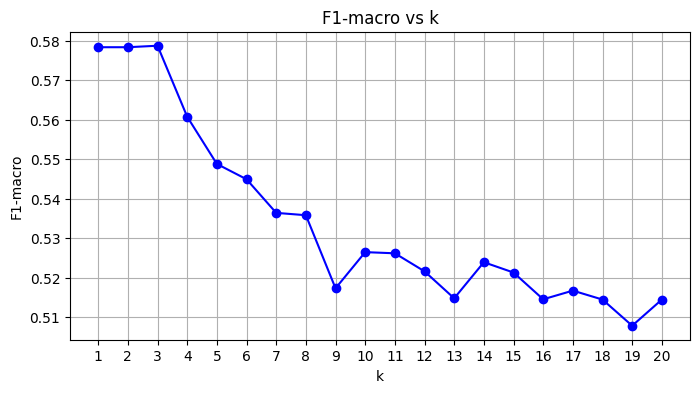

In [41]:
plt.figure(figsize=(8,4))
plt.plot(k_values, f1_scores, marker="o", color="blue")
plt.xlabel("k")
plt.ylabel("F1-macro")
plt.title("F1-macro vs k")
plt.xticks(k_values)
plt.grid(True)
plt.show()



REENTRENO EL MODELO

In [42]:
best_k = k_values[f1_scores.index(max(f1_scores))]
print(f"Mejor k por F1-macro: {best_k} (F1-macro = {max(f1_scores):.4f})")

best_model = KNeighborsClassifier(n_neighbors=best_k, weights="distance")
best_model.fit(X_train_scaled, y_train_res)



Mejor k por F1-macro: 3 (F1-macro = 0.5788)


,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


EVALUO

In [43]:
y_pred_final = best_model.predict(X_test_scaled)

print("Accuracy final:", accuracy_score(y_test, y_pred_final))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred_final))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_final, zero_division=0))




Accuracy final: 0.75625

Matriz de confusión:
 [[  7   6   0]
 [ 28 201  35]
 [  0   9  34]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.20      0.54      0.29        13
           1       0.93      0.76      0.84       264
           2       0.49      0.79      0.61        43

    accuracy                           0.76       320
   macro avg       0.54      0.70      0.58       320
weighted avg       0.84      0.76      0.78       320



In [44]:
def predict_wine_quality(values):
    if len(values) != X.shape[1]:
        raise ValueError(f"Debes pasar exactamente {X.shape[1]} valores. Pasaste {len(values)}.")
    values_df = pd.DataFrame([values], columns=X.columns)
    scaled = scaler.transform(values_df)
    pred = best_model.predict(scaled)[0]
    mapping = {0:"Baja calidad", 1:"Calidad media", 2:"Alta calidad"}
    return f"Este vino probablemente sea de {mapping[pred]}"





In [45]:
y_pred_final = best_model.predict(X_test_scaled)
print("\nF1-macro final:", f1_score(y_test, y_pred_final, average="macro"))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred_final))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_final))


F1-macro final: 0.5787698412698412

Matriz de confusión:
 [[  7   6   0]
 [ 28 201  35]
 [  0   9  34]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.20      0.54      0.29        13
           1       0.93      0.76      0.84       264
           2       0.49      0.79      0.61        43

    accuracy                           0.76       320
   macro avg       0.54      0.70      0.58       320
weighted avg       0.84      0.76      0.78       320



In [46]:
ejemplos_baja = data[data["label"]==0].sample(2, random_state=42)
ejemplos_media = data[data["label"]==1].sample(2, random_state=42)
ejemplos_alta = data[data["label"]==2].sample(2, random_state=42)

for df in [ejemplos_baja, ejemplos_media, ejemplos_alta]:
    for idx, fila in df.iterrows():
        valores = fila[X.columns].tolist()
        pred = predict_wine_quality(valores)
        print(f"Vino índice {idx} -> Predicción: {pred}, Calidad real: {fila['quality']}")


Vino índice 1505 -> Predicción: Este vino probablemente sea de Baja calidad, Calidad real: 3.0
Vino índice 1478 -> Predicción: Este vino probablemente sea de Baja calidad, Calidad real: 3.0
Vino índice 785 -> Predicción: Este vino probablemente sea de Calidad media, Calidad real: 5.0
Vino índice 1286 -> Predicción: Este vino probablemente sea de Calidad media, Calidad real: 6.0
Vino índice 1459 -> Predicción: Este vino probablemente sea de Alta calidad, Calidad real: 7.0
Vino índice 1549 -> Predicción: Este vino probablemente sea de Alta calidad, Calidad real: 8.0


In [47]:
baja = data[data["label"]==0].iloc[0][X.columns].tolist()
alta = data[data["label"]==2].iloc[0][X.columns].tolist()

print("Predicción ejemplo baja:", predict_wine_quality(baja))
print("Predicción ejemplo alta:", predict_wine_quality(alta))

Predicción ejemplo baja: Este vino probablemente sea de Baja calidad
Predicción ejemplo alta: Este vino probablemente sea de Alta calidad
